Requirements

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

Dataset Description

Columns:
engine_id
cycle
Operational settings (3 columns)
Sensor readings (21 columns typically)

Data visualization

Load data

In [3]:
# Load CMAPSS training set (change file name if needed)
df = pd.read_csv("DATA/train_FD001.txt", sep=r"\s+", header=None)

print("Shape:", df.shape)
df.head()

Shape: (20631, 26)


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


Add column names

In [4]:
col_names = (
    ["engine_id", "cycle"] +
    [f"os{i}" for i in range(1, 4)] +      # operating settings 1–3
    [f"s{i}" for i in range(1, 22)]        # sensors 1–21
)

df.columns = col_names
df.head()

,engine_id,cycle,os1,os2,os3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


overview of the data

In [5]:
df.info()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   engine_id  20631 non-null  int64  
 1   cycle      20631 non-null  int64  
 2   os1        20631 non-null  float64
 3   os2        20631 non-null  float64
 4   os3        20631 non-null  float64
 5   s1         20631 non-null  float64
 6   s2         20631 non-null  float64
 7   s3         20631 non-null  float64
 8   s4         20631 non-null  float64
 9   s5         20631 non-null  float64
 10  s6         20631 non-null  float64
 11  s7         20631 non-null  float64
 12  s8         20631 non-null  float64
 13  s9         20631 non-null  float64
 14  s10        20631 non-null  float64
 15  s11        20631 non-null  float64
 16  s12        20631 non-null  float64
 17  s13        20631 non-null  float64
 18  s14        20631 non-null  float64
 19  s15        20631 non-null  float64
 20  s16   

,count,mean,std,min,25%,50%,75%,max
engine_id,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
cycle,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
os1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
os2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
os3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
s1,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
s2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s5,20631.0,14.620000,5.329200e-15,14.6200,14.6200,14.6200,14.6200,14.6200


Number of cycles per engine

Number of engines: 100
Cycles per engine (first 10):
engine_id
1     192
2     287
3     179
4     189
5     269
6     188
7     259
8     150
9     201
10    222
Name: cycle, dtype: int64


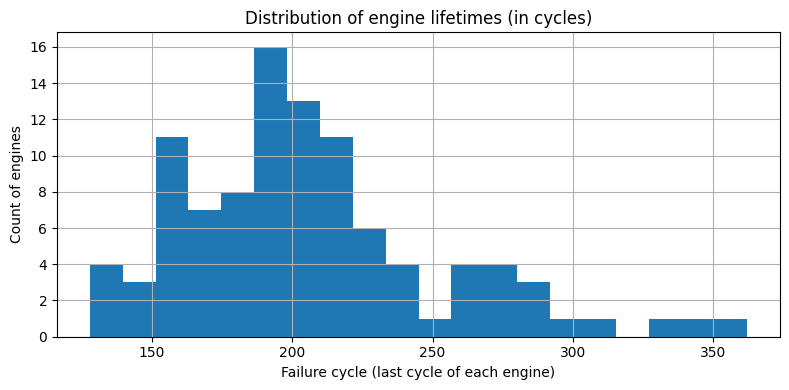

In [6]:
cycles_per_engine = df.groupby("engine_id")["cycle"].max()

print("Number of engines:", df["engine_id"].nunique())
print("Cycles per engine (first 10):")
print(cycles_per_engine.head(10))

plt.figure(figsize=(8, 4))
cycles_per_engine.hist(bins=20)
plt.xlabel("Failure cycle (last cycle of each engine)")
plt.ylabel("Count of engines")
plt.title("Distribution of engine lifetimes (in cycles)")
plt.tight_layout()
plt.show()


Plot some sensor trajectories for a few engines

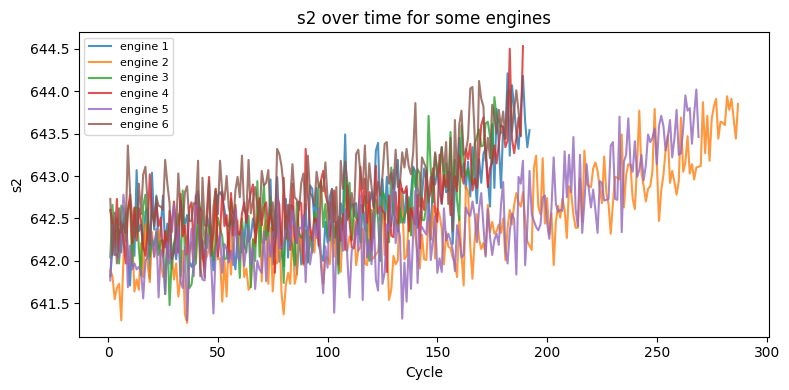

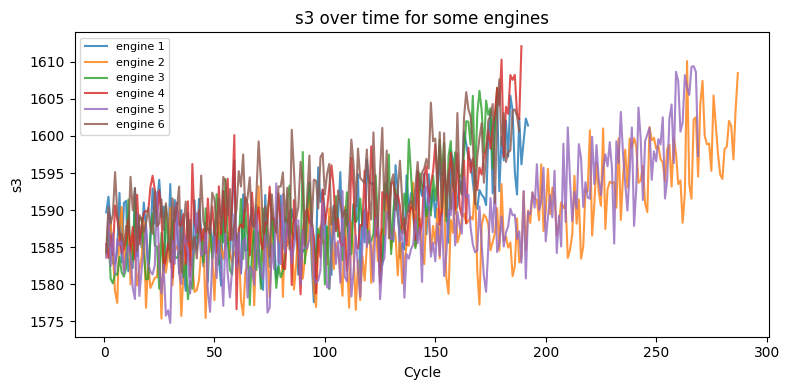

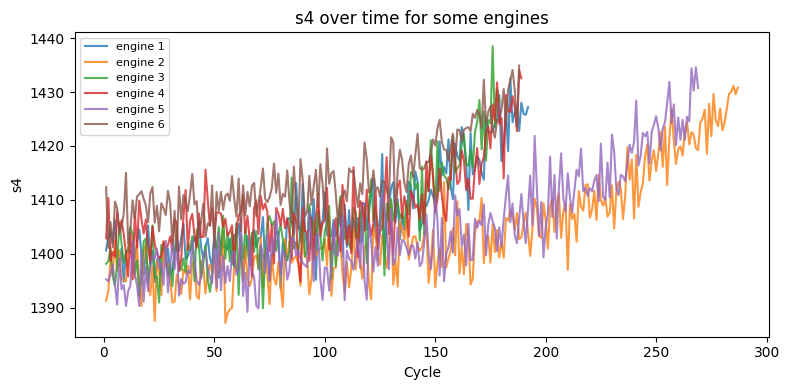

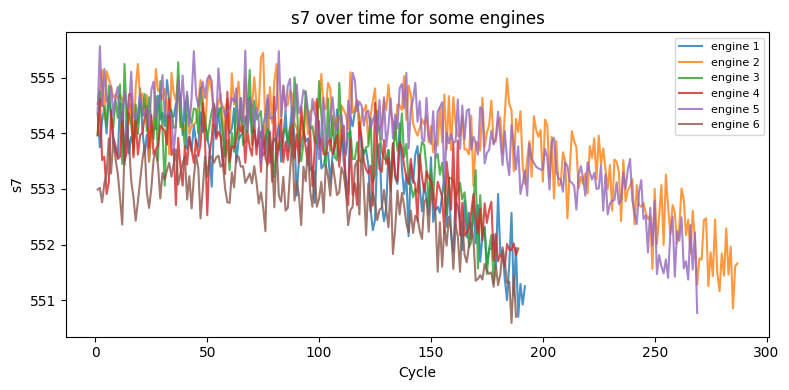

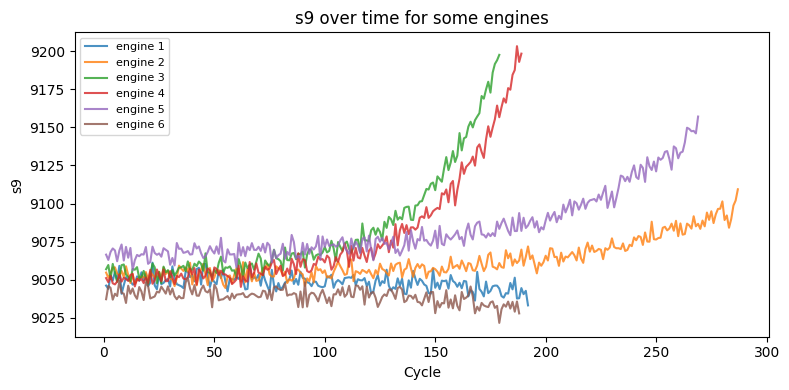

In [ ]:
# pick a few engines to visualize
sample_engines = df["engine_id"].unique()[:6]   

sensors_to_plot = ["s2", "s3", "s4", "s7", "s9"]  

for sensor in sensors_to_plot:
    plt.figure(figsize=(8, 4))
    for eid in sample_engines:
        sub = df[df["engine_id"] == eid]
        plt.plot(sub["cycle"], sub[sensor], alpha=0.8, label=f"engine {eid}")
    plt.xlabel("Cycle")
    plt.ylabel(sensor)
    plt.title(f"{sensor} over time for some engines")
    plt.legend(loc="best", fontsize=8)
    plt.tight_layout()
    plt.show()


5. Correlation heatmap between sensors

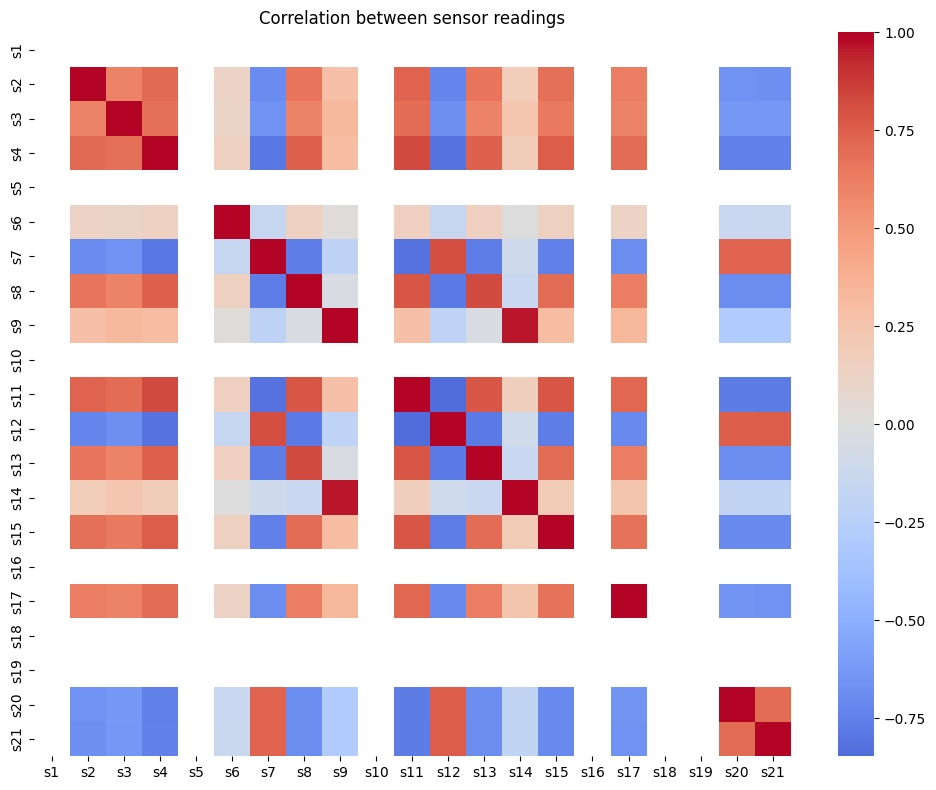

In [8]:
sensor_cols = [c for c in df.columns if c.startswith("s")]

plt.figure(figsize=(10, 8))
corr = df[sensor_cols].corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation between sensor readings")
plt.tight_layout()
plt.show()


6. Distribution of a few sensors (histograms)

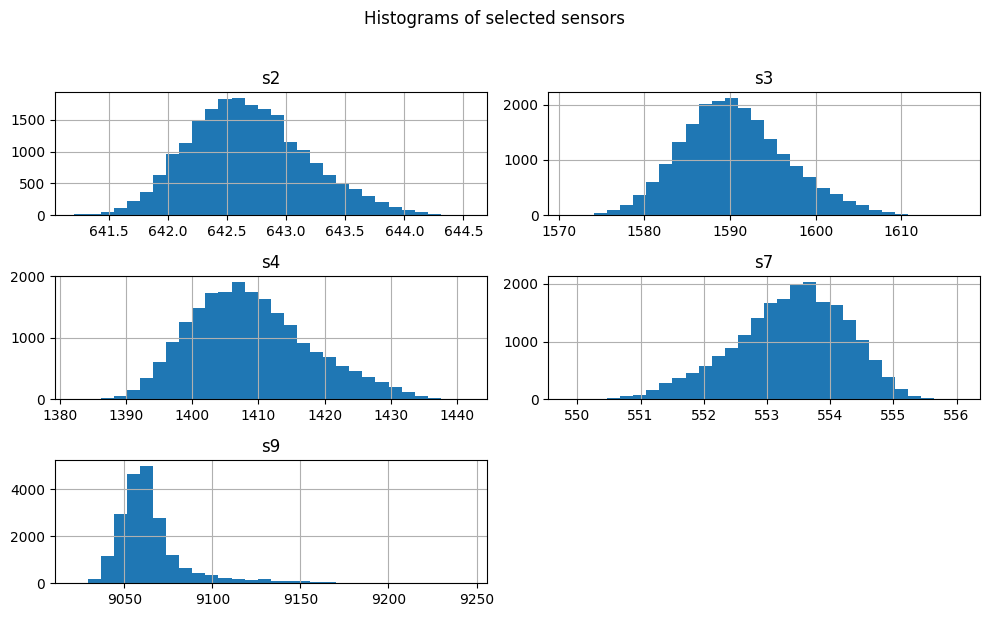

In [9]:
df[sensors_to_plot].hist(figsize=(10, 6), bins=30)
plt.suptitle("Histograms of selected sensors", y=1.02)
plt.tight_layout()
plt.show()

Droping constant features

In [12]:
op_cols = [f"os{i}" for i in range(1, 4)]
sensor_cols = [f"s{i}" for i in range(1, 22)]
feature_cols = op_cols + sensor_cols

# Work directly on raw df (non-normalized)
df_features = df[feature_cols]

# Standard deviation per feature
stds = df_features.std()

print("Std per feature:")
print(stds)

# Exactly constant features (std == 0)
constant_cols = stds[stds == 0].index.tolist()

# Almost constant: choose a small threshold if you want to be stricter


print("Exactly constant features:", constant_cols)


# Decide what to drop – here we drop low-variance ones
cols_to_drop = constant_cols  # or constant_cols if you want only strictly constant
selected_features = [c for c in feature_cols if c not in cols_to_drop]

print("Keeping these features:", selected_features)

# This is what you'll use for IsolationForest
X_raw = df[selected_features].values


Std per feature:
os1    2.187313e-03
os2    2.930621e-04
os3    0.000000e+00
s1     0.000000e+00
s2     5.000533e-01
s3     6.131150e+00
s4     9.000605e+00
s5     5.329200e-15
s6     1.388985e-03
s7     8.850923e-01
s8     7.098548e-02
s9     2.208288e+01
s10    0.000000e+00
s11    2.670874e-01
s12    7.375534e-01
s13    7.191892e-02
s14    1.907618e+01
s15    3.750504e-02
s16    3.469531e-18
s17    1.548763e+00
s18    0.000000e+00
s19    0.000000e+00
s20    1.807464e-01
s21    1.082509e-01
dtype: float64
Exactly constant features: ['os3', 's1', 's10', 's18', 's19']
Keeping these features: ['os1', 'os2', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's20', 's21']


Normalize the kept features before models

In [19]:
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

IsolationForest

In [ ]:


iso = IsolationForest(
    n_estimators=200,
    contamination=0.05,   
    random_state=42
)

iso.fit(X)

# Anomaly scores (higher = more normal in sklearn; lower = more anomalous)
scores = iso.score_samples(X)

# Predictions: 1 = normal, -1 = anomaly
labels = iso.predict(X)

df_iso = df.copy()
df_iso["iso_score"] = scores
df_iso["iso_label"] = labels   # 1 normal, -1 anomaly

df_iso.head()
pd.set_option("display.max_rows", 200)  


RUL (Remaining Useful Life)

In [16]:
# 1) Find failure cycle per engine
max_cycles = df.groupby("engine_id")["cycle"].max().reset_index()
max_cycles.columns = ["engine_id", "max_cycle"]

# 2) Merge back to original df
df_rul = df.merge(max_cycles, on="engine_id", how="left")

# 3) Compute RUL
df_rul["RUL"] = df_rul["max_cycle"] - df_rul["cycle"]

df_rul[["engine_id", "cycle", "max_cycle", "RUL"]].head(10)


,engine_id,cycle,max_cycle,RUL
0,1,1,192,191
1,1,2,192,190
2,1,3,192,189
3,1,4,192,188
4,1,5,192,187
5,1,6,192,186
6,1,7,192,185
7,1,8,192,184
8,1,9,192,183
9,1,10,192,182
